# Perceptrón multicapa

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar un perceptrón multicapa para la tarea de clasificación de imágenes. Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Tiene imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

![Lecun](../figs/yan_lecun.png)


## 1 Carga de datos

Comenzaremos descargando y leyendo el conjunto de datos. Aprovecharemos que Tensorflow cuenta con utilerias en el paquete [`tf.keras.datasets`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/datasets) para descargar conjuntos de datos de referencia preprocesados.

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

tf.random.set_seed(2019)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Una vez descargadas las imágenes, podemos visualizar algunas para ver cómo lucen.

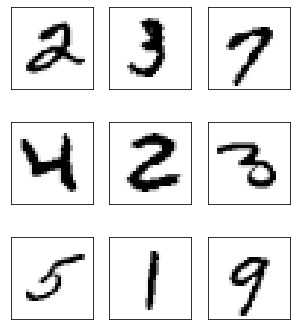

In [2]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[5 * i], cmap='Greys')

Ahora normalizamos las imágenes.

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = y_train[..., tf.newaxis]
y_test = y_test[..., tf.newaxis]
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

Definimos nuestra tubería de datos para el conjunto de entrenamiento.

In [4]:
batch_size = 64
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.shuffle(60000)
ds = ds.batch(batch_size)

for x, y_true in ds:
    print('x={} x.shape={}'.format(x.numpy().flatten(), x.shape))
    print('y_true={} y_true.shape={}'.format(y_true.numpy().flatten(), y_true.shape))
    break

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
x=[0. 0. 0. ... 0. 0. 0.] x.shape=(64, 28, 28)
y_true=[2 6 0 7 8 7 5 7 7 4 4 4 3 2 3 7 7 6 3 7 0 3 1 3 1 6 1 3 1 0 6 4 9 9 4 0 5
 9 8 8 0 9 2 1 6 1 3 0 7 6 7 0 1 8 7 7 1 7 3 7 9 7 0 3] y_true.shape=(64, 1)


### Quiz 1

¿Cúal es la función de activación adecuada para la capa de salida de una red neuronal para clasificación multiclase?

## 2 Definición del modelo

In [5]:
class MLP(Model):

  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = Flatten(name='flatten')
    self.fc1 = Dense(128, name='hiden')
    self.fc2 = Dense(10, name='output')

  def call(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = tf.nn.sigmoid(x)
    x = self.fc2(x)
    x = tf.nn.softmax(x)
    return x

In [6]:
model = MLP()
model.build(input_shape=(None, 784))
model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
hiden (Dense)                multiple                  100480    
_________________________________________________________________
output (Dense)               multiple                  1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Quiz 2

¿Comó sacamos las cuentitas del número de parámeros de las capas?

### Quiz 3

Si las clases fueran 100 en vez de 10 y quisera utilizar la misma arquitectura anterior ¿qué modificación tendría que realizar? 

### Definición de pérdida y optimizador

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

### Definición de métricas

Las clases dentro de `tf.keras.metrics` están diseñadas para mantener un histórico de una métrica a lo largo de los pasas de entrenamiento y agregarlo (con el promedio por ejemplo) para obtener el desempeño de la métrica a nivel epoca.

In [8]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.SparseCategoricalCrossentropy()
acc_epoch = tf.keras.metrics.SparseCategoricalAccuracy()

## 3 Entrenamiento

In [9]:
#########################################################
# se crea una marca de tiempo
model_name = datetime.now().strftime('%y%m%d-%H%M%S')
# se crea una ruta para almacenar las métricas
train_dir = 'logs/{}/train'.format(model_name)
# se crea un escritor
train_writer = tf.summary.create_file_writer(train_dir)
print("Trainig model {}".format(model_name))

##########################################################
# decorador para producir la gráfica de cómputo estática
@tf.function
def train_step(x, y_true, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn(y_true, y_pred)            
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return y_pred

##########################################################
# visualización de la gráfica en tensorboard
# habilitamos el rastreo del flujo de cómputo para tensorboard
tf.summary.trace_on()
# se ejecuta el modelo
train_step(x_train[0:1], y_train[0:1], model, loss_fn, optimizer) 
# activo el contexto del escritor
with train_writer.as_default():
    # exporto la gráfica
    tf.summary.trace_export(model_name, 0)

##########################################################
# ciclo de entrenamiento
epochs = 20
for epoch in range(epochs):

    for x, y_true in ds:
        y_pred = train_step(x, y_true, model, loss_fn, optimizer)
            
        loss_epoch(y_true, y_pred)
        acc_epoch(y_true, y_pred)

    loss_val = loss_epoch.result().numpy() * 100
    acc_val = acc_epoch.result().numpy() * 100
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    # escribimos las métricas
    with train_writer.as_default():
        tf.summary.scalar('loss', loss_val, epoch)
        tf.summary.scalar('acc', acc_val, epoch)

    print('E{:2d} loss={:6.2f}, acc={:6.2f}'.format(epoch, loss_val, acc_val))

Trainig model 190910-123201
E 0 loss=227.99, acc= 19.75
E 1 loss=212.42, acc= 47.60
E 2 loss=201.15, acc= 58.60
E 3 loss=190.41, acc= 64.68
E 4 loss=180.13, acc= 68.01
E 5 loss=170.33, acc= 70.20
E 6 loss=161.02, acc= 71.96
E 7 loss=152.25, acc= 73.45
E 8 loss=144.07, acc= 74.98
E 9 loss=136.47, acc= 75.97
E10 loss=129.49, acc= 77.00
E11 loss=123.09, acc= 77.99
E12 loss=117.25, acc= 78.97
E13 loss=111.92, acc= 79.62
E14 loss=107.08, acc= 80.24
E15 loss=102.68, acc= 80.91
E16 loss= 98.67, acc= 81.40
E17 loss= 95.02, acc= 81.84
E18 loss= 91.67, acc= 82.34
E19 loss= 88.62, acc= 82.74


## 4 Validación

In [10]:
y_pred_test = model(x_test)
print(acc_epoch(y_test, y_pred_test).numpy() * 100)

83.74999761581421


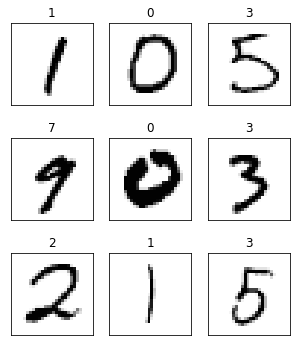

In [11]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[5*i], cmap='Greys')
    plt.title(y_pred_test[5*i].numpy().argmax())